<a href="https://colab.research.google.com/github/ascillitoe/EQ-live/blob/master/Blog_posts/regularisation/post_regularisation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains code for the blog post "Regularisation 1: Handling real-world data" located on the *equadratures* discourse [here](https://discourse.equadratures.org/t/regularisation-the-bias-variance-tradeoff/132) (and on my personal website [here](https://ascillitoe.com/posts/2021/regularised-polynomials/)\). See the posts for further commentary.

In [ ]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install git+https://github.com/Effective-Quadratures/equadratures.git@develop # for specific branch

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import equadratures as eq
from equadratures import datasets
from copy import deepcopy
from tqdm import tqdm

  Cloning https://github.com/Effective-Quadratures/equadratures.git (to revision develop) to /tmp/pip-req-build-7qtqmepi
  Running command git clone -q https://github.com/Effective-Quadratures/equadratures.git /tmp/pip-req-build-7qtqmepi
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Created wheel for equadratures: filename=equadratures-9.1.0-cp37-none-any.whl size=132541 sha256=f759581487427a54b1ad4ae9067a327ad5ec11063f73ef1c2c69c8e9d569bf60
  Stored in directory: /tmp/pip-ephem-wheel-cache-jv6phyye/wheels/83/29/c9/85b4dae59060f70c5a2f0eec5f51a665061d2393108b74db65
Successfully built equadratures


# High order polynomials

## Ordinary least squares regression
Lets start by creating a simple polynomial regression class. The $k^{th}$ order 1D polynomial

$$
y_i = \beta_0 + \beta_1 x_i +\beta_2 x_i^2 + \dots + \beta_k x_i^k \;\;\;\;\; i = [1,\dots,N]
$$

can be written as a linear algebra problem

$$
\boldsymbol{y} = \mathbf{A}\boldsymbol{\beta}
$$

$$
\begin{bmatrix} y_1\\ y_2\\ y_3 \\ \vdots \\ y_N \end{bmatrix}= \begin{bmatrix} 1 & x_1 & x_1^2 & \dots & x_1^k \\ 1 & x_2 & x_2^2 & \dots & x_2^k \\ 1 & x_3 & x_3^2 & \dots & x_3^k \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & x_N & x_N^2 & \dots & x_N^k \end{bmatrix} \begin{bmatrix} \beta_0\\ \beta_1\\ \beta_2\\ \vdots \\ \beta_k \end{bmatrix}
$$

Performing a regression is then a case of finding the polynomial coefficients $\boldsymbol{\beta}$. This can be done using the `numpy` least squares solver `linalg.lstsq`, which seeks to minimise the loss term:

$$
\lVert \boldsymbol{y} -\mathbf{A}\boldsymbol{\beta} \rVert_2^2
$$


In [ ]:
class linear:
    """A simple linear regression class"""
    def __init__(self,order=1):
        self.order=order
    
    def fit(self,X,y):
        n = X.shape[0]
        if len(X.shape)==1: X = X.reshape(-1,1)
        if len(y.shape)==1: y = y.reshape(-1,1)
        
        A = np.ones(n).reshape(-1,1)
        for k in range(1,self.order+1):
            A = np.concatenate([A,np.power(X,k)],axis=1)
        coeffs = np.linalg.lstsq(A, y, rcond=None)[0]
        self.X = X
        self.y = y
        self.coeffs = coeffs
        
    def predict(self,X):
        n = X.shape[0]
        if len(X.shape)==1: X = X.reshape(-1,1)
        A = np.ones(n).reshape(-1,1)
        for k in range(1,self.order+1):
            A = np.concatenate([A,np.power(X,k)],axis=1)        
        ypred = np.dot(A,self.coeffs.reshape(-1,1))
        return ypred.reshape(-1,1)

Now lets use this to approximate the trigonometric function

$$
y = 0.2\sin(5x) + 0.05\cos(x) - 0.8\sin(0.1x)
$$


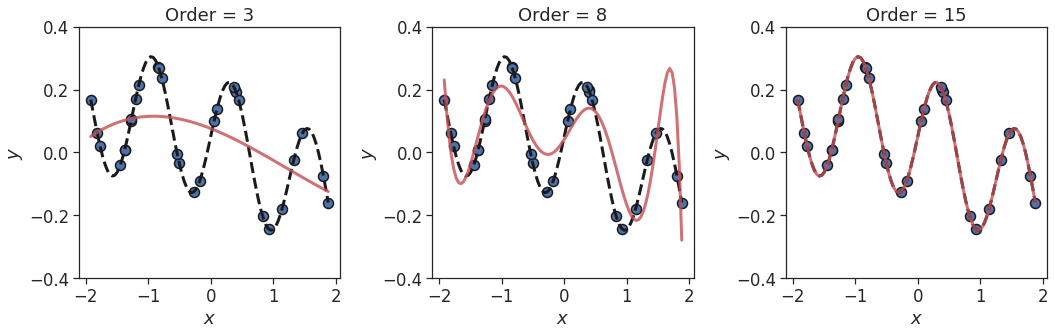

In [ ]:
# Create function and data
X = np.random.RandomState(42).uniform(-2,2,30)
Xplot = np.linspace(np.min(X),np.max(X),100)
fx = lambda X: 0.2*np.sin(5*X) + 0.05*np.cos(X) - 0.8*np.sin(0.1*X)
#fx = lambda X: (X**3 - 5*X**2 - X + 2)/10
y = fx(X)

# Try different orders
fig, ax = plt.subplots(1,3,figsize=(15,5),tight_layout=True)
for i, order in enumerate([3,8,15]):
    # Fit Poly
    model = linear(order=order)
    model.fit(X,y)
    y_pred = model.predict(Xplot)

    # Plot
    ax[i].set_title('Order = %d' %(order))
    ax[i].plot(X, y, 'C0o', ms=10, mec='k', mew=1.5, label='Training observations')
    ax[i].plot(Xplot, fx(Xplot), '--k', lw=3, label='Truth')
    ax[i].plot(Xplot, y_pred, '-C3', lw=3, label='Poly. approx.', alpha=0.8)
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
    ax[i].set_ylim([-0.4,0.4])
    #ax[i].legend()
plt.show()

Looking good! But how about if we had some noise to the data?

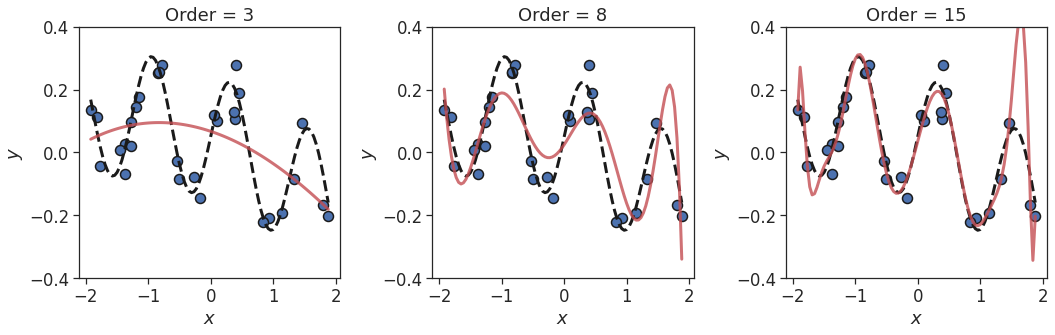

In [ ]:
noise = 0.1
ynew = y + np.random.RandomState(41).uniform(-0.1,0.1,len(y))

# Try different orders
fig, ax = plt.subplots(1,3,figsize=(15,5),tight_layout=True)
for i, order in enumerate([3,8,15]):
    # Fit Poly
    modelnoise = linear(order=order)
    modelnoise.fit(X,ynew)
    y_pred = modelnoise.predict(Xplot)

    # Plot
    ax[i].set_title('Order = %d' %(order))
    ax[i].plot(X, ynew, 'C0o', ms=10, mec='k', mew=1.5, label='Training observations')
    ax[i].plot(Xplot, fx(Xplot), '--k', lw=3, label='Truth')
    ax[i].plot(Xplot, y_pred, '-C3', lw=3, label='Poly. approx.', alpha=0.8)
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
    ax[i].set_ylim([-0.4,0.4])
    #ax[i].legend()
plt.show()

## Looking at the polynomial coefficients
To understand why overfitting is occuring with the $k=15$ polynomial, lets plot the polynomial coefficients without and with noise.

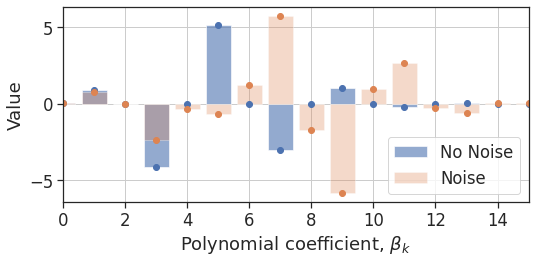

In [ ]:
figs, ax = plt.subplots(tight_layout=True,figsize=(8,4))
ax.set_xlabel(r'Polynomial coefficient, $\beta_k$')
ax.set_ylabel('Value')
ax.set_xlim([0,order]) 
ax.grid()
ax.bar(np.arange(order+1),model.coeffs.reshape(-1),alpha=0.6,label='No Noise')
ax.plot(np.arange(order+1),model.coeffs.reshape(-1),'o',label='_nolegend_')
ax.bar(np.arange(order+1),modelnoise.coeffs.reshape(-1),alpha=0.3,label='Noise')
ax.plot(np.arange(order+1),modelnoise.coeffs.reshape(-1),'o',label='_nolegend_')
plt.legend(loc='lower right')
plt.show()

## Ridge regression
Ridge regression minimises the squared residual (L2norm) with a L2 penality term.

$$
\lVert \boldsymbol{y} -\mathbf{A}\boldsymbol{\beta} \rVert_2^2 +\lambda||\boldsymbol{\beta}||_2^2
$$



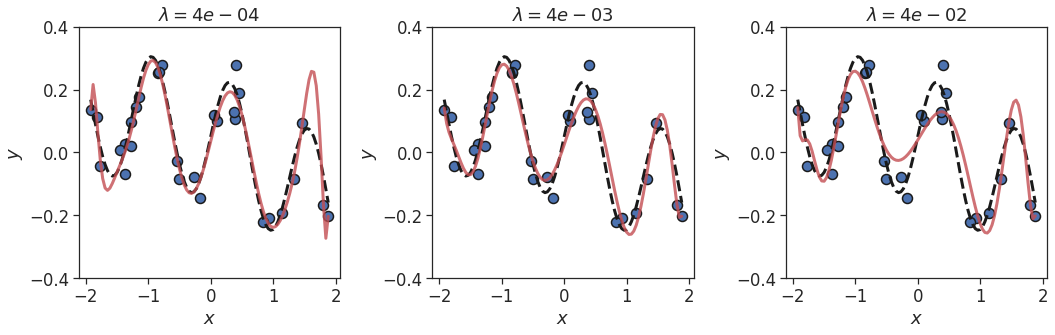

In [ ]:
class ridge(linear):
    def fit(self,X,y,lamda):
        solver = eq.solver.elastic_net({'path':False,'lambda':lamda,'alpha':0.001})

        n = X.shape[0]
        if len(X.shape)==1: X = X.reshape(-1,1)
        if len(y.shape)==1: y = y.reshape(-1,1)
        
        A = np.ones(n).reshape(-1,1)
        for k in range(1,self.order+1):
            A = np.concatenate([A,np.power(X,k)],axis=1)
        coeffs = solver.get_coefficients(A,y)
        self.X = X
        self.y = y
        self.coeffs = coeffs

# Try different orders
fig, ax = plt.subplots(1,3,figsize=(15,5),tight_layout=True)
for i, lamda in enumerate([0.0004,0.004,0.04]):
    # Fit Poly
    newmodel = ridge(order=15)
    newmodel.fit(X,ynew,lamda)
    y_pred = newmodel.predict(Xplot)

    # Plot
    ax[i].set_title(r'$\lambda = %.0e$' %(lamda))
    ax[i].plot(X, ynew, 'C0o', ms=10, mec='k', mew=1.5, label='Training observations')
    ax[i].plot(Xplot, fx(Xplot), '--k', lw=3, label='Truth')
    ax[i].plot(Xplot, y_pred, '-C3', lw=3, label='Poly. approx.', alpha=0.8)
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
    ax[i].set_ylim([-0.4,0.4])
    #ax[i].legend()
plt.show()

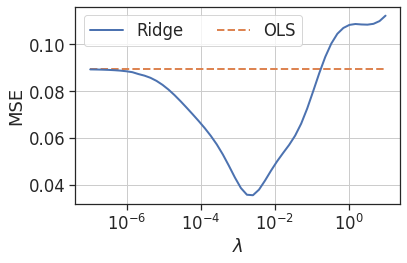

In [ ]:
# Error versus lambda
Nlamda = 50
lamdas = np.logspace(-7,1,Nlamda)
mse = np.empty(Nlamda)
for i, lamda in enumerate(lamdas):
    # Fit Poly
    newmodel = ridge(order=15)
    newmodel.fit(X,ynew,lamda)
    y_pred = newmodel.predict(Xplot)
    mse[i] = np.sqrt(np.mean((y_pred.squeeze()-fx(Xplot))**2))

model = linear(order=15)
model.fit(X,ynew)
mse_ols = np.sqrt(np.mean((model.predict(Xplot).squeeze()-fx(Xplot))**2))

fig, ax = plt.subplots(figsize=(6,4),tight_layout=True)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('MSE')
ax.set_xscale('log')
ax.plot(lamdas,mse,'-',label='Ridge',lw=2)
ax.hlines(mse_ols,lamdas[0],lamdas[-1],ls='--',color='C1',label='OLS',lw=2)
ax.grid(True)
ax.legend(ncol=2)

#  Feature selection for high dimensional datasets
We consider the well-known piston problem from Kenett et al. that is a non-linear, seven-dimensional problem that outputs the piston cycle time given various piston parameters. These parameters and their bounds are shown in the table below.

<img src="https://discourse.equadratures.org/uploads/default/original/1X/766b3b3e6329378216ce89f90e6b40f3645f675a.png" width="50%">

The cycle time for the piston is given by

$$
C=2\pi\sqrt{\frac{M}{k+S^{2}\frac{P_{0}V_{0}T_{a}}{T_{0}V^{2}}}},
$$

where

$$
V=\frac{S}{2k}\left(\sqrt{A^{2}+4k\frac{P_{0}V_{0}}{T_{0}}T_{a}}-A\right),
$$

and $A=P_{0}S+19.62M-\frac{kV_{0}}{S}$. The estimated *unnormalized* Sobol' indices ($\tau_i^2$) from Kenett et al. are given to be:

<img src="https://discourse.equadratures.org/uploads/default/original/1X/28b06c7bcfe338b5cc0cd9db3666545eec1173da.png" width="50%">

We randomly sample these parameters $N=1000$ times, and further split this data 70/30 for training/testing. Finally, two extra noise parameters are added, and a little noise is added to the dependent variable $C$.








In [ ]:
N = 1000
order_parameters = 3
noise = 1.0
Nnoise = 2

# Define parameters
mass = eq.Parameter(distribution='uniform', lower=30.0, upper=60.0, order=order_parameters)
area = eq.Parameter(distribution='uniform', lower=0.005, upper=0.020, order=order_parameters)
volume = eq.Parameter(distribution='uniform', lower=0.002, upper=0.010, order=order_parameters)
spring = eq.Parameter(distribution='uniform', lower=1000., upper=5000., order=order_parameters)
pressure = eq.Parameter(distribution='uniform', lower=90000., upper=110000., order=order_parameters)
ambtemp = eq.Parameter(distribution='uniform', lower=290., upper=296., order=order_parameters)
gastemp = eq.Parameter(distribution='uniform', lower=340., upper=360., order=order_parameters)
parameters = [mass, area, volume, spring, pressure, ambtemp, gastemp]
d = len(parameters)

# Define model
def piston(x):
  mass, area, volume, spring, pressure, ambtemp, gastemp = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
  A = pressure * area + 19.62*mass - (spring * volume)/(1.0 * area)
  V = (area/(2*spring)) * ( np.sqrt(A**2 + 4*spring * pressure * volume * ambtemp/gastemp) - A)
  C = 2 * np.pi * np.sqrt(mass/(spring + area**2 * pressure * volume * ambtemp/(gastemp * V**2)))
  return C

# Randomly sample parameters N times and evaluate model at these sample points
X = np.empty([N,d+Nnoise])
for j in range(d):
  x = parameters[j].get_samples(N)
  X[:,j] = x
y = piston(X.T) + np.random.RandomState(42).normal(0.0,0.15,N)

# Add irrelevent noise parameters to X
for j in range(d,d+Nnoise):
  X[:,j] = np.random.RandomState(42).uniform(-noise,noise,N)
  parameters.append(eq.Parameter(distribution='uniform', lower=-noise, upper=noise, order=order_parameters))

# Split into train and test data (70/30 train/test)
X_train, X_test, y_train, y_test = eq.datasets.train_test_split(X,y,random_seed=42)

Now lets fit the 3rd order polynomials, using OLS and LASSO regression. LASSO regression minimises the the squared residual (L2norm) with a L1 penality term.

$$
\lVert \boldsymbol{y} -\mathbf{A}\boldsymbol{\beta} \rVert_2^2 +\lambda||\boldsymbol{\beta}||_1
$$


In [ ]:
# Define the basis and polynomials
mybasis = eq.Basis('total-order')
olspoly = eq.Poly(parameters=parameters, basis=mybasis, method='least-squares', \
          sampling_args= {'mesh': 'user-defined', 'sample-points':X_train, 'sample-outputs': y_train})
lassopoly = eq.Poly(parameters=parameters, basis=mybasis, method='elastic-net', \
          sampling_args= {'mesh': 'user-defined', 'sample-points':X_train, 'sample-outputs': y_train},
          solver_args={'path':False,'alpha':1.0,'lambda':6.25e-03})
olspoly.set_model()
lassopoly.set_model()

### Model interpretation with Sobol' indicies
Comparing the estimated *unnormalized* Sobol' indices ($\tau_i^2$) from the OLS and LASSO polynomials, to the *true indices* from Kenett et al.

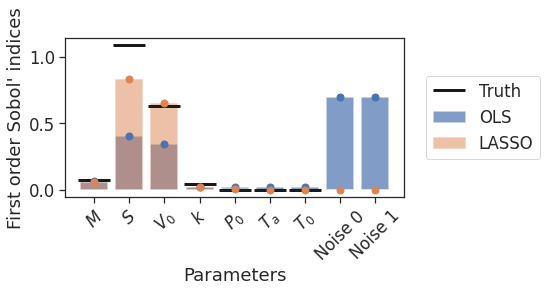

In [ ]:
# Plot the estimated Sobol indices and compare to the true indices
fig,ax = plt.subplots(tight_layout=True,figsize=(8,4))
ax.set_xlabel(r'Parameters')
ax.set_ylabel(r"First order Sobol' indices")
xTickMarks = [r'$M$', r'$S$', r'$V_0$', r'$k$', r'$P_0$', r'$T_a$', r'$T_0$']
for j in range(0,Nnoise):
  xTickMarks.append('Noise %d' %j)
ax.set_xticks(np.arange(d+Nnoise)+1)
xtickNames = ax.set_xticklabels(xTickMarks,rotation=45)

# True Sobol values from Owen
true_sobol = [0.073,1.088,0.626,0.040,0.001,-0.002,-0.002]
ax.plot(np.arange(len(true_sobol))+1,true_sobol, '_k', ms=32, mew=3,label='Truth')

# OLS Sobol indices
mean, var = olspoly.get_mean_and_variance()
sobol = olspoly.get_sobol_indices(1)
sobol_ols = [sobol[(i,)]* 10.0**2 * var for i in range(len(sobol))]
ax.bar(np.arange(len(sobol))+1, sobol_ols, color='C0',linewidth=1.5,alpha=0.7,label='OLS')
ax.plot(np.arange(len(sobol))+1, sobol_ols, 'oC0', ms=7,label='_nolegend_')

# LASSO Sobol indices
mean, var = lassopoly.get_mean_and_variance()
sobol = lassopoly.get_sobol_indices(1)
sobol_lasso = [sobol[(i,)]* 10.0**2 * var for i in range(len(sobol))]
ax.bar(np.arange(len(sobol))+1, sobol_lasso, color='C1',linewidth=1.5,alpha=0.5,label='LASSO')
ax.plot(np.arange(len(sobol))+1, sobol_lasso, 'oC1', ms=7,label='_nolegend_')

ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.show()

### Test accuracy
Finally, lets examine the performance across the full range of LASSO $\lambda$ values by plotting the *test* MSE versus $\lambda$.

100%|██████████| 50/50 [00:27<00:00,  1.82it/s]


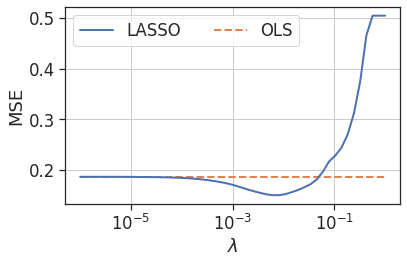

In [ ]:
# Plot test MSE vs lambda for LASSO (really we should do Kfold or similiar cross validation here, but skip for this demo)
Nlamda = 50
lamdas = np.logspace(-6,0,Nlamda)
mse = np.empty(Nlamda)
for i, lamda in enumerate(tqdm(lamdas)):
  lassopoly = eq.Poly(parameters=parameters, basis=mybasis, method='elastic-net', \
          sampling_args= {'mesh': 'user-defined', 'sample-points':X_train, 'sample-outputs': y_train},
          solver_args={'path':False,'alpha':1.0,'lambda':lamda})
  lassopoly.set_model()
  mse[i] = np.sqrt(np.mean((lassopoly.get_polyfit(X_test).squeeze()-y_test)**2))

mse_ols = np.sqrt(np.mean((olspoly.get_polyfit(X_test).squeeze()-y_test)**2))

fig, ax = plt.subplots(figsize=(6,4),tight_layout=True)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('MSE')
ax.set_xscale('log')
ax.plot(lamdas,mse,'-',label='LASSO',lw=2)
ax.hlines(mse_ols,lamdas[0],lamdas[-1],ls='--',color='C1',label='OLS',lw=2)
ax.grid(True)
ax.legend(ncol=2)

The optimal $\lambda$ value is... 

In [ ]:
idx = np.argmin(mse)
print('Minimum MSE is %.3f at lambda = %.2e' %(mse[idx],lamdas[idx]))

Minimum MSE is 0.150 at lambda = 6.25e-03
